In [143]:
 #We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5.0

In [ ]:
#Connecting Drive to save model checkpoints during training and to use custom data, uncomment if needed

# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Permute, Lambda, Embedding, Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [3]:
#Hyperparameters

hop=80               #hop size (window size = 6*hop)
sr=22050              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [144]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

""" ********************NOTE: This is used for mel-spectrogram generation through torchaudio and waveform reconstruction through a gradient based method. It's offline; this means, it's
used during training. CONSIDER if it will be necessary to alter the waveform reconstruction if extra input (encoding) is added. """

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor') #Requires GPU

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True) #Transform that creates spectrogram from audio signal
specfunc = specobj.forward 
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.) #Turns STFT into a mel frequency STFT
melfunc = melobj.forward

def melspecfunc(waveform): #function that transforms audio file into spectrogram
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target): #Unsure what this is. I assume it's a method for calculating spectral difference
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003): #For waveform reconstruction, a gradient-based method is used:

    spec = torch.Tensor(spec) #takes in spectrogram
    samples = (spec.shape[-1]*hop)-hop #takes last dimension 

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu() #detach returns new tensor detached from current graph, with a different shape

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1) #-1,1 normalization

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db #denormalization

def prep(wv,hop=80):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu()) #I believe this is for online spectrogram creation. Transforms tensor
  S = librosa.power_to_db(S)-ref_level_db #by changing shape, turning it into mel, squeezing it, detaching from graph, operating in cpu and turning into np.
  return normalize(S) #it then transforms it to db 

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8) #reconstruction of waveform through denormalisation, return to power and gradient method
  return np.array(np.squeeze(wv))

In [145]:
#Helper functions

#Generate spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object) #return array of certain size without initializing entries
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*22050):
  x, sr = librosa.load(path,sr=22050)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

def splitcut_target(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

  

In [146]:
speaker_ids = {'F01':0, 'F03':1, 'F04':2, 'M01':3, 'M02':4, 'M03':5, 'M04':6, 'M05': 7}

def create_speaker_vector(speaker_dict):
  speaker_vectors = []
  for key, value in speaker_dict.items():
    speaker_vectors.append(np.full((16, 24), value))
  
  return speaker_vectors

vectors_ids = create_speaker_vector(speaker_ids)

#Order: 'F01':0, 'F03':1, 'F04':2, 'M01':3, 'M02':4, 'M03':5, 'M04':6, 'M05': 7



In [147]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#CONTROL1

awv = audio_array('/content/INP')                             
aspec = tospec(awv)                                                            
adata = splitcut(aspec)      
print(adata.shape)



#DYSARTHRIC 1

m01wv = audio_array('/content/OUT')

m01spec = tospec(m01wv)
bdata = splitcut(m01spec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(152,)
(748, 80, 240, 1)
(123,)


In [148]:
#Creating Tensorflow Datasets

@tf.function
def proc(x):
  return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

In [149]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [150]:

new_id_vector = np.ones((bs, shape))

#print(new_id_vector.shape)
#print(new_id_vector)

OLIVER'S CODE - DEBUGGING FOR GENERATOR

In [151]:

def build_generator_DEBUG_EMBEDDINGS(input_shape):
  h,w,c = input_shape # 80, 24, 1
  # Inputs
  inp = Input(shape=input_shape) # shape: 80, 24, 1 = mels, timesteps, single channel
  speaker_v_input = Input(shape=(w)) # shape: 24
  print(f"Shape of speaker input: {speaker_v_input.shape}")
  # Getting embeddings - shape: (None, 24, 2)
  embedding_out = tf.keras.layers.Embedding(8, 2, input_length=w)(speaker_v_input) # assume 8 possible speakers, 2 is the dimensionality of embedding
  
  # Change shape to (None, 2, 24)
  embedding_out = Permute([2,1])(embedding_out) # "Permutation pattern does not include the samples dimension. Indexing starts at 1."

  #Adding extra dimension for channel
  embedding_out = tf.expand_dims(embedding_out, axis=-1) #> None, 2, 24, 1

  #Concatenate speaker embedding to input

  concat_out = Concatenate(axis=1)([inp, embedding_out]) # Concatenate embedding to input > None, 82, 24, 1
  concat_out = tf.squeeze(concat_out, axis=-1) #> 82, 24
  concat_out = Permute([2,1])(concat_out)
  reshaped = Dense(80)(concat_out)
  reshaped = Permute([2,1])(reshaped)
  reshaped = tf.expand_dims(reshaped, axis=-1)

  print(f"reshaped: {reshaped.shape}")

  
  
  #Model predicts concat_out from input and speaker embedding

  
  return Model([inp, speaker_v_input],reshaped, name='G')


We want the input + embedding to be concatenated and reshaped, and then to be used to predict target spectrogram.

In [32]:
### --- test it ----

### OSW - these are terrible variable names - shape is non-specific and uninformative 
### and hop is just misleading in most of the places it is used.
### [Don't worry Patricia - I know this is inherited baggage and not your fault :-) ]
hop=80                # hop size (window size = 6*hop) ### OSW - confusingly, also n_mels=hop !!!!
shape=24              # length of time axis of split specrograms to feed to generator  


BATCH_WITH_SINGLE_SAMPLE = 1 

gen = build_generator_DEBUG_EMBEDDINGS((hop, shape, 1))
#gen.summary()

dummy_audio_in = np.random.normal(size=(BATCH_WITH_SINGLE_SAMPLE, hop, shape, 1))
speaker_1_index = np.ones((BATCH_WITH_SINGLE_SAMPLE, shape)) ## 
if len(speaker_1_index[0]) < 16:
  print("True")
else:
  print("Ok")


output = gen.predict([dummy_audio_in, speaker_1_index])

print (output)

print (output.shape)


Shape of speaker input: (None, 24)
reshaped: (None, 80, 24, 1)
Ok
[[[[ 1.1825056 ]
   [-0.17791182]
   [-1.0490377 ]
   ...
   [-0.7857555 ]
   [ 1.5906872 ]
   [ 0.28365582]]

  [[-0.1441637 ]
   [-0.55729294]
   [ 0.7736636 ]
   ...
   [ 1.1065562 ]
   [ 0.7646098 ]
   [-0.2872311 ]]

  [[ 0.6649333 ]
   [ 1.6884155 ]
   [ 0.49196735]
   ...
   [ 1.8676207 ]
   [ 1.1324662 ]
   [-0.6052295 ]]

  ...

  [[ 1.0847857 ]
   [-0.46334034]
   [ 0.2782668 ]
   ...
   [ 0.5886092 ]
   [-0.16325256]
   [-0.9952661 ]]

  [[ 0.1755234 ]
   [ 0.11577505]
   [-0.46448067]
   ...
   [ 0.33882985]
   [ 1.7561584 ]
   [ 0.01420286]]

  [[ 0.13272363]
   [ 1.9114935 ]
   [-1.9791365 ]
   ...
   [-1.4547368 ]
   [ 0.11515999]
   [ 0.49151182]]]]
(1, 80, 24, 1)


END OF DEBUGGING CODE 

In [152]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shapes):
  h,w,c = input_shapes # 80, 24, 1, except at test time, where batch size usually > 16
  # Inputs
  inp = Input(shape=input_shapes) # shape: 80, 24, 1


  #TRAINING - BATCH SIZE == None
  #if inp.shape[0] == None: 
  print("Training; BS == None")
  speaker_v_input = Input(shape=(w))
  print(f"Shape of speaker input: {speaker_v_input.shape}") #None, 24
  # Getting embeddings
  embedding_out = tf.keras.layers.Embedding(8, 2, input_length=w)(speaker_v_input) # assume 8 possible speakers, 2 is the dimensionality of embedding.> None, 24, 2
  print(f"Embedding out shape: {embedding_out.shape}")
  #Change shape to (None, 2, 24)
  embedding_out = Permute([2,1])(embedding_out) #None, 2, 24
  embedding_out = tf.expand_dims(embedding_out, axis=-1) #None, 2, 24, 1
  concat_out = Concatenate(axis=1)([inp, embedding_out]) # Concatenate embedding to input > None, 82, 24, 1
    

  """else: #TESTING TIME - BATCH SIZE != NONE
      batch_size = inp.shape[0]
      speaker_v_input = Input(shape=(16, 24)) #16, 24
      speaker_v_input = Permute([1, 0])(speaker_v_input) #24, 16
      speaker_v_input = Dense(batch_size)(speaker_v_input) #24, batch_size
      speaker_v_input = Permute([0, 1])(speaker_v_input) #bs, 24
      print(f"Shape of speaker input: {speaker_v_input.shape}")
      # Getting embeddings
      embedding_out = tf.keras.layers.Embedding(8, 2, input_length=w)(speaker_v_input) # bs, 24, 2
      print(f"Embedding out shape: {embedding_out.shape}")
      #Change shape to (bs, 2, 24)
      embedding_out = Permute([2,1])(embedding_out) #bs, 2, 24
      embedding_out = tf.expand_dims(embedding_out, axis=-1) #bs, 2, 24, 1
      concat_out = Concatenate(axis=2)([inp, embedding_out]) # Concatenate embedding to input > bs, 82, 24, 1
    """
     
 #Getting back original shape
  """concat_out = tf.squeeze(concat_out, axis=-1) # Squeezing to be able to use Permute > 82, 24
  concat_out = Permute([2,1])(concat_out) # Permute, to be able to use Dense layer > 24, 82
  reshaped = Dense(80)(concat_out) # Using dense layer to reduce last dimension > 24, 80 ¿¿¿¿???
  reshaped = Permute([2,1])(reshaped) # > 80, 24
  reshaped = tf.expand_dims(reshaped, axis=-1) #> 80, 24,1"""

  # Processing concatenated input
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(concat_out)
  g1 = conv2d(g0, 256, kernel_size=(h+2,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  print(f"Shape of g6: {g6.shape}")
  

  return Model([inp, speaker_v_input],g6, name='G')


#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=(input_shape))

  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=(h,w,c)) # shape: 80, 24
  print(f"Input shape of critic: {inp.shape}")

  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  print(f"Critic after flattening: {g4}")
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  print(g4)
  return Model(inp, g4, name='C')

In [170]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  bs = a.shape[0]
  generating_vec = np.ones((bs, 24)) #We create a different speaker vector at test time, since the batch size wil be != 16
  ab = gen([a,generating_vec], training=False) 
  print("Results mid-training for generation of random spectrograms and audio files. ")
  gen.summary()
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='../content/'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [154]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [155]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [171]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  aa,aa2,aa3 = extract_image(a) 
  bb,bb2,bb3 = extract_image(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    #translating A to B
    fab = gen([aa, new_id_vector], training=True)
    fab2 = gen([aa2, new_id_vector], training=True)
    fab3 = gen([aa3, new_id_vector], training=True)
    #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
    fid = gen([bb, new_id_vector], training=True) 
    fid2 = gen([bb2, new_id_vector], training=True)
    fid3 = gen([bb3, new_id_vector], training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])
    print(f"Fabtot shape: {fabtot.shape}")
    print("GENERATOR SUMMARY")
    gen.summary()

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    print("CRITIC SUMMARY ")
    critic.summary()

    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)
    print("SIAMESE SUMMARY")
    siam.summary()

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  with tf.GradientTape() as tape_disc:

    fab = gen([aa,new_id_vector], training=True)
    fab2 = gen([aa2,new_id_vector], training=True)
    fab3 = gen([aa3,new_id_vector], training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [172]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=2, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  c = 0
  g = 0
  
  for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
                      

In [173]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path='../content/drive/My Drive/')

Training; BS == None
Shape of speaker input: (None, 24)
Embedding out shape: (None, 24, 2)
Shape of g6: (None, 80, 24, 1)
Input shape of critic: (None, 80, 72, 1)
Critic after flattening: KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten_31/Reshape:0', description="created by layer 'flatten_31'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_sn_15/BiasAdd:0', description="created by layer 'dense_sn_15'")
Built networks


Fabtot shape: (16, 80, 72, 1)
GENERATOR SUMMARY
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0                                            
__________________________________________________

  6%|▌         | 110/2000 [00:00<00:02, 649.98it/s, loss=1.14e-6, spectral_convergence=-.978]

Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0                                            
_____________________

100%|██████████| 2000/2000 [00:03<00:00, 663.73it/s, loss=1.05e-7, spectral_convergence=3.76]


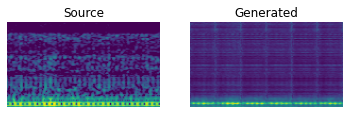

Mean D loss: 0.5273221731185913 Mean G loss: 1.045362114906311 Mean ID loss: 0.18365181982517242
[Epoch 1/40] [Batch 0] [D loss f: 0.6390931606292725 r: 0.6112651228904724] [G loss: 0.8033548593521118] [ID loss: 0.12024441361427307] [LR: 0.0002]
[Epoch 1/40] [Batch 600] [D loss f: 0.5985150337219238 r: 0.6223062872886658] [G loss: 0.8496197462081909] [ID loss: 0.12115463614463806] [LR: 0.0002]
[Epoch 1/40] [Batch 1200] [D loss f: 0.5869287252426147 r: 0.6109319925308228] [G loss: 0.8562921285629272] [ID loss: 0.11808695644140244] [LR: 0.0002]
[Epoch 1/40] [Batch 1800] [D loss f: 0.5911670923233032 r: 0.6165414452552795] [G loss: 0.7807405591011047] [ID loss: 0.11569157987833023] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=1.95e-6, spectral_convergence=5.69]

Time/Batch 0.034105954044453254
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 643.93it/s, loss=2.26e-7, spectral_convergence=-3.11]


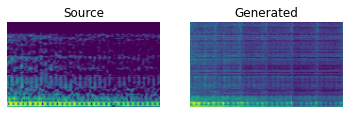

Mean D loss: 0.5871996879577637 Mean G loss: 0.8133360743522644 Mean ID loss: 0.11802270263433456
[Epoch 2/40] [Batch 0] [D loss f: 0.5645285248756409 r: 0.6134489178657532] [G loss: 0.7335636615753174] [ID loss: 0.11650411784648895] [LR: 0.0002]
[Epoch 2/40] [Batch 600] [D loss f: 0.5721508860588074 r: 0.6082313060760498] [G loss: 0.7337748408317566] [ID loss: 0.11632087826728821] [LR: 0.0002]
[Epoch 2/40] [Batch 1200] [D loss f: 0.610244870185852 r: 0.6045700907707214] [G loss: 0.6624040007591248] [ID loss: 0.10946899652481079] [LR: 0.0002]
[Epoch 2/40] [Batch 1800] [D loss f: 0.6055025458335876 r: 0.6054418683052063] [G loss: 0.6731783747673035] [ID loss: 0.11413133889436722] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0457, spectral_convergence=-.00953]

Time/Batch 0.034120429174484115
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 652.11it/s, loss=0.00249, spectral_convergence=-18.8]


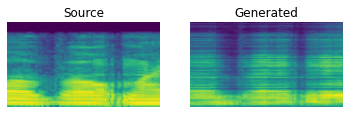

Mean D loss: 0.5951977968215942 Mean G loss: 0.6791253685951233 Mean ID loss: 0.11301128566265106
[Epoch 3/40] [Batch 0] [D loss f: 0.5920939445495605 r: 0.6206347942352295] [G loss: 0.6253625154495239] [ID loss: 0.11159121245145798] [LR: 0.0002]
[Epoch 3/40] [Batch 600] [D loss f: 0.615419328212738 r: 0.6194128394126892] [G loss: 0.6099308729171753] [ID loss: 0.11863303929567337] [LR: 0.0002]
[Epoch 3/40] [Batch 1200] [D loss f: 0.603569746017456 r: 0.6129566431045532] [G loss: 0.5987609624862671] [ID loss: 0.12463004142045975] [LR: 0.0002]
[Epoch 3/40] [Batch 1800] [D loss f: 0.5924681425094604 r: 0.634218156337738] [G loss: 0.6572309732437134] [ID loss: 0.11994984745979309] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.71e-6, spectral_convergence=-1.88]

Time/Batch 0.03409414366404804
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 640.58it/s, loss=3.11e-7, spectral_convergence=-3.93]


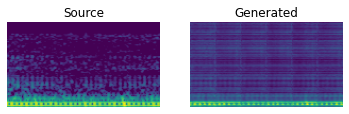

Mean D loss: 0.6023167967796326 Mean G loss: 0.6161776185035706 Mean ID loss: 0.12139344960451126
[Epoch 4/40] [Batch 0] [D loss f: 0.5922538638114929 r: 0.6301797032356262] [G loss: 0.589966893196106] [ID loss: 0.12296818941831589] [LR: 0.0002]
[Epoch 4/40] [Batch 600] [D loss f: 0.5894936919212341 r: 0.6262763738632202] [G loss: 0.6076294779777527] [ID loss: 0.1154690533876419] [LR: 0.0002]
[Epoch 4/40] [Batch 1200] [D loss f: 0.5686542987823486 r: 0.6330422163009644] [G loss: 0.635312020778656] [ID loss: 0.12412381172180176] [LR: 0.0002]
[Epoch 4/40] [Batch 1800] [D loss f: 0.5591930150985718 r: 0.6585468053817749] [G loss: 0.6122586131095886] [ID loss: 0.12116410583257675] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0715, spectral_convergence=-.00238]

Time/Batch 0.03412865853210336
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 641.12it/s, loss=0.00142, spectral_convergence=-17]


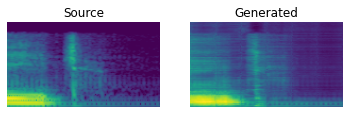

Mean D loss: 0.5719912648200989 Mean G loss: 0.6272150874137878 Mean ID loss: 0.119890496134758
[Epoch 5/40] [Batch 0] [D loss f: 0.5701318383216858 r: 0.6556140780448914] [G loss: 0.6706496477127075] [ID loss: 0.11819013208150864] [LR: 0.0002]
[Epoch 5/40] [Batch 600] [D loss f: 0.5668327212333679 r: 0.6530537605285645] [G loss: 0.6209205985069275] [ID loss: 0.11750557273626328] [LR: 0.0002]
[Epoch 5/40] [Batch 1200] [D loss f: 0.5444268584251404 r: 0.6736261248588562] [G loss: 0.6166151762008667] [ID loss: 0.1196860522031784] [LR: 0.0002]
[Epoch 5/40] [Batch 1800] [D loss f: 0.5401502251625061 r: 0.6614238023757935] [G loss: 0.6411486268043518] [ID loss: 0.12230021506547928] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0809, spectral_convergence=-.00277]

Time/Batch 0.034116628488861045
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 630.60it/s, loss=0.00213, spectral_convergence=-18.5]


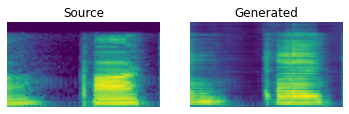

Mean D loss: 0.5527427196502686 Mean G loss: 0.6271149516105652 Mean ID loss: 0.12075155228376389
[Epoch 6/40] [Batch 0] [D loss f: 0.5643301010131836 r: 0.6670200228691101] [G loss: 0.631256103515625] [ID loss: 0.12543363869190216] [LR: 0.0002]
[Epoch 6/40] [Batch 600] [D loss f: 0.5768877863883972 r: 0.6780920028686523] [G loss: 0.598186731338501] [ID loss: 0.11488135159015656] [LR: 0.0002]
[Epoch 6/40] [Batch 1200] [D loss f: 0.5582457184791565 r: 0.6742905974388123] [G loss: 0.657545268535614] [ID loss: 0.11625850945711136] [LR: 0.0002]
[Epoch 6/40] [Batch 1800] [D loss f: 0.5432634353637695 r: 0.6839497089385986] [G loss: 0.5816845893859863] [ID loss: 0.12082511931657791] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0249, spectral_convergence=-.0057]

Time/Batch 0.0342251489913778
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0           

100%|██████████| 2000/2000 [00:03<00:00, 627.33it/s, loss=0.000237, spectral_convergence=-26.4]


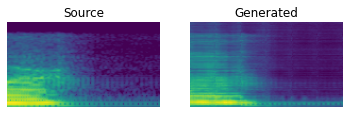

Mean D loss: 0.5602265000343323 Mean G loss: 0.6121395230293274 Mean ID loss: 0.1172851100564003
[Epoch 7/40] [Batch 0] [D loss f: 0.5640331506729126 r: 0.6796931624412537] [G loss: 0.6104159951210022] [ID loss: 0.11693957448005676] [LR: 0.0002]
[Epoch 7/40] [Batch 600] [D loss f: 0.5475705862045288 r: 0.6994325518608093] [G loss: 0.6136856079101562] [ID loss: 0.11349005252122879] [LR: 0.0002]
[Epoch 7/40] [Batch 1200] [D loss f: 0.5382952094078064 r: 0.6994268894195557] [G loss: 0.6351540088653564] [ID loss: 0.11477778106927872] [LR: 0.0002]
[Epoch 7/40] [Batch 1800] [D loss f: 0.5277717709541321 r: 0.7059882283210754] [G loss: 0.6295085549354553] [ID loss: 0.11457688361406326] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.117, spectral_convergence=-.00254]

Time/Batch 0.03408732010445513
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 612.47it/s, loss=0.00106, spectral_convergence=-26.7]


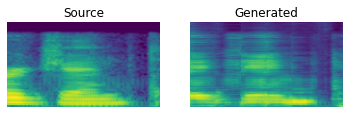

Mean D loss: 0.5372700691223145 Mean G loss: 0.621856689453125 Mean ID loss: 0.11485850811004639
[Epoch 8/40] [Batch 0] [D loss f: 0.5340476036071777 r: 0.7213564515113831] [G loss: 0.6009258031845093] [ID loss: 0.11811797320842743] [LR: 0.0002]
[Epoch 8/40] [Batch 600] [D loss f: 0.5490748286247253 r: 0.7037414312362671] [G loss: 0.5821977257728577] [ID loss: 0.11301038414239883] [LR: 0.0002]
[Epoch 8/40] [Batch 1200] [D loss f: 0.5315244793891907 r: 0.7479605674743652] [G loss: 0.6131078004837036] [ID loss: 0.11636815220117569] [LR: 0.0002]
[Epoch 8/40] [Batch 1800] [D loss f: 0.5260341167449951 r: 0.7517446875572205] [G loss: 0.6395105719566345] [ID loss: 0.11826670169830322] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.64e-6, spectral_convergence=-5.14]

Time/Batch 0.0342247429847276
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0           

100%|██████████| 2000/2000 [00:03<00:00, 602.75it/s, loss=3.19e-7, spectral_convergence=-3.34]


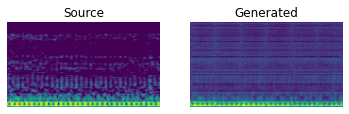

Mean D loss: 0.5394858717918396 Mean G loss: 0.609782874584198 Mean ID loss: 0.11608447879552841
[Epoch 9/40] [Batch 0] [D loss f: 0.5587463974952698 r: 0.7404333353042603] [G loss: 0.6010035872459412] [ID loss: 0.11666170507669449] [LR: 0.0002]
[Epoch 9/40] [Batch 600] [D loss f: 0.5326381921768188 r: 0.7642929553985596] [G loss: 0.651496171951294] [ID loss: 0.11231435090303421] [LR: 0.0002]
[Epoch 9/40] [Batch 1200] [D loss f: 0.5341545343399048 r: 0.7603796124458313] [G loss: 0.61539226770401] [ID loss: 0.11231778562068939] [LR: 0.0002]
[Epoch 9/40] [Batch 1800] [D loss f: 0.515110433101654 r: 0.7794550657272339] [G loss: 0.6267086863517761] [ID loss: 0.11451523005962372] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03414704467565138
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 616.93it/s, loss=1.08e-6, spectral_convergence=-32.1]


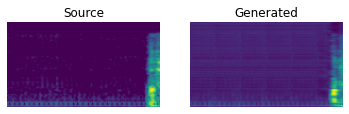

Mean D loss: 0.5253847241401672 Mean G loss: 0.6304807066917419 Mean ID loss: 0.11365725845098495
[Epoch 10/40] [Batch 0] [D loss f: 0.5151287317276001 r: 0.7923396825790405] [G loss: 0.6279474496841431] [ID loss: 0.11678446829319] [LR: 0.0002]
[Epoch 10/40] [Batch 600] [D loss f: 0.5120125412940979 r: 0.7870473861694336] [G loss: 0.6306658387184143] [ID loss: 0.11483077704906464] [LR: 0.0002]
[Epoch 10/40] [Batch 1200] [D loss f: 0.5157882571220398 r: 0.7914289832115173] [G loss: 0.6738653779029846] [ID loss: 0.10972152650356293] [LR: 0.0002]
[Epoch 10/40] [Batch 1800] [D loss f: 0.5285833477973938 r: 0.7883309125900269] [G loss: 0.5945217609405518] [ID loss: 0.10941904783248901] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.149, spectral_convergence=-.000315]

Time/Batch 0.03412236785623885
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 611.72it/s, loss=0.000686, spectral_convergence=-24.1]


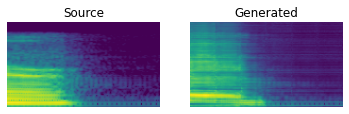

Mean D loss: 0.5205309987068176 Mean G loss: 0.6286126375198364 Mean ID loss: 0.11194605380296707
[Epoch 11/40] [Batch 0] [D loss f: 0.5292115807533264 r: 0.7806229591369629] [G loss: 0.6078038215637207] [ID loss: 0.11520582437515259] [LR: 0.0002]
[Epoch 11/40] [Batch 600] [D loss f: 0.5018676519393921 r: 0.7958739995956421] [G loss: 0.6722757816314697] [ID loss: 0.11390324681997299] [LR: 0.0002]
[Epoch 11/40] [Batch 1200] [D loss f: 0.5134248733520508 r: 0.796801745891571] [G loss: 0.620231032371521] [ID loss: 0.11403573304414749] [LR: 0.0002]
[Epoch 11/40] [Batch 1800] [D loss f: 0.5102983117103577 r: 0.811808168888092] [G loss: 0.6302942037582397] [ID loss: 0.11222407221794128] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.175, spectral_convergence=-.00217]

Time/Batch 0.03422980162899895
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 617.27it/s, loss=0.00144, spectral_convergence=-23.1]


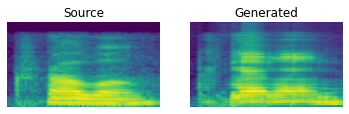

Mean D loss: 0.5047646760940552 Mean G loss: 0.647411048412323 Mean ID loss: 0.11238522082567215
[Epoch 12/40] [Batch 0] [D loss f: 0.4885893762111664 r: 0.8425628542900085] [G loss: 0.6756470203399658] [ID loss: 0.10725200176239014] [LR: 0.0002]
[Epoch 12/40] [Batch 600] [D loss f: 0.5198475122451782 r: 0.8079147338867188] [G loss: 0.6232246160507202] [ID loss: 0.10981632024049759] [LR: 0.0002]
[Epoch 12/40] [Batch 1200] [D loss f: 0.5252558588981628 r: 0.8096285462379456] [G loss: 0.5933710932731628] [ID loss: 0.11321945488452911] [LR: 0.0002]
[Epoch 12/40] [Batch 1800] [D loss f: 0.5036617517471313 r: 0.8290120363235474] [G loss: 0.6208950877189636] [ID loss: 0.11218736320734024] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.02e-6, spectral_convergence=-3.03]

Time/Batch 0.034149976087797025
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 610.73it/s, loss=1.99e-7, spectral_convergence=-2.79]


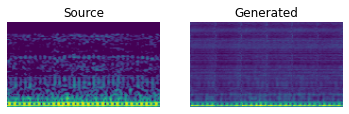

Mean D loss: 0.5116540193557739 Mean G loss: 0.6189630627632141 Mean ID loss: 0.11185872554779053
[Epoch 13/40] [Batch 0] [D loss f: 0.4877563714981079 r: 0.8314621448516846] [G loss: 0.6521048545837402] [ID loss: 0.11229657381772995] [LR: 0.0002]
[Epoch 13/40] [Batch 600] [D loss f: 0.5006718635559082 r: 0.8423658609390259] [G loss: 0.6414994597434998] [ID loss: 0.11061752587556839] [LR: 0.0002]
[Epoch 13/40] [Batch 1200] [D loss f: 0.4942131042480469 r: 0.833448588848114] [G loss: 0.639875054359436] [ID loss: 0.10877520591020584] [LR: 0.0002]
[Epoch 13/40] [Batch 1800] [D loss f: 0.5311399102210999 r: 0.8443036675453186] [G loss: 0.6256666779518127] [ID loss: 0.10266995429992676] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.43e-6, spectral_convergence=-5.03]

Time/Batch 0.034132837863058915
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 600.44it/s, loss=2.55e-7, spectral_convergence=-3.56]


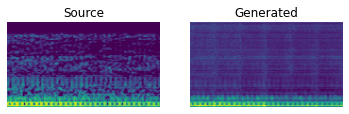

Mean D loss: 0.5089125633239746 Mean G loss: 0.6397361755371094 Mean ID loss: 0.10683019459247589
[Epoch 14/40] [Batch 0] [D loss f: 0.5085923075675964 r: 0.8423927426338196] [G loss: 0.6624364852905273] [ID loss: 0.10430170595645905] [LR: 0.0002]
[Epoch 14/40] [Batch 600] [D loss f: 0.5274931788444519 r: 0.8030130863189697] [G loss: 0.6385090351104736] [ID loss: 0.10614943504333496] [LR: 0.0002]
[Epoch 14/40] [Batch 1200] [D loss f: 0.5176638960838318 r: 0.8509368300437927] [G loss: 0.6277258396148682] [ID loss: 0.10956253111362457] [LR: 0.0002]
[Epoch 14/40] [Batch 1800] [D loss f: 0.489195853471756 r: 0.8524506688117981] [G loss: 0.6603138446807861] [ID loss: 0.11021733283996582] [LR: 0.0002]
Time/Batch 0.03418857617711425
Saving...


  4%|▍         | 90/2000 [00:00<00:03, 627.30it/s, loss=0.144, spectral_convergence=-.752]

(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0                                            
______

100%|██████████| 2000/2000 [00:03<00:00, 603.35it/s, loss=0.00191, spectral_convergence=-14.5]


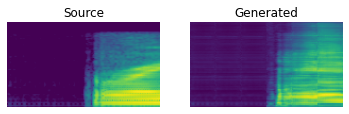

Mean D loss: 0.5124301910400391 Mean G loss: 0.6418814659118652 Mean ID loss: 0.10831685364246368
[Epoch 15/40] [Batch 0] [D loss f: 0.5191335678100586 r: 0.8362566828727722] [G loss: 0.6375163197517395] [ID loss: 0.10674235224723816] [LR: 0.0002]
[Epoch 15/40] [Batch 600] [D loss f: 0.5024904608726501 r: 0.8588491082191467] [G loss: 0.6442118287086487] [ID loss: 0.10902814567089081] [LR: 0.0002]
[Epoch 15/40] [Batch 1200] [D loss f: 0.5125797390937805 r: 0.8421424627304077] [G loss: 0.6354761719703674] [ID loss: 0.10678854584693909] [LR: 0.0002]
[Epoch 15/40] [Batch 1800] [D loss f: 0.4985220432281494 r: 0.8739939332008362] [G loss: 0.6288180351257324] [ID loss: 0.11035149544477463] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.173, spectral_convergence=-.000305]

Time/Batch 0.034156957967917935
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 601.72it/s, loss=0.000134, spectral_convergence=-48.1]


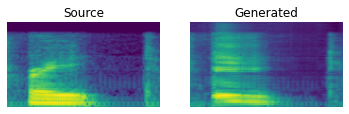

Mean D loss: 0.5047743320465088 Mean G loss: 0.6353947520256042 Mean ID loss: 0.10781873017549515
[Epoch 16/40] [Batch 0] [D loss f: 0.5062061548233032 r: 0.8671979308128357] [G loss: 0.6313924193382263] [ID loss: 0.10322456806898117] [LR: 0.0002]
[Epoch 16/40] [Batch 600] [D loss f: 0.5230109095573425 r: 0.863052487373352] [G loss: 0.589976966381073] [ID loss: 0.11259066313505173] [LR: 0.0002]
[Epoch 16/40] [Batch 1200] [D loss f: 0.4987313747406006 r: 0.874529242515564] [G loss: 0.6599804759025574] [ID loss: 0.10494997352361679] [LR: 0.0002]
[Epoch 16/40] [Batch 1800] [D loss f: 0.5066589117050171 r: 0.8698156476020813] [G loss: 0.6114503741264343] [ID loss: 0.10440214723348618] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=4.75e-6, spectral_convergence=-5.47]

Time/Batch 0.03421596110501481
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 595.24it/s, loss=7.65e-7, spectral_convergence=-13]


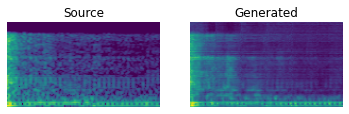

Mean D loss: 0.5073534250259399 Mean G loss: 0.6226271390914917 Mean ID loss: 0.10791798681020737
[Epoch 17/40] [Batch 0] [D loss f: 0.4953368008136749 r: 0.8766188621520996] [G loss: 0.6348011493682861] [ID loss: 0.11093521863222122] [LR: 0.0002]
[Epoch 17/40] [Batch 600] [D loss f: 0.5019659399986267 r: 0.8637581467628479] [G loss: 0.6285920143127441] [ID loss: 0.10177189111709595] [LR: 0.0002]
[Epoch 17/40] [Batch 1200] [D loss f: 0.5136581659317017 r: 0.871995210647583] [G loss: 0.5833049416542053] [ID loss: 0.10303620994091034] [LR: 0.0002]
[Epoch 17/40] [Batch 1800] [D loss f: 0.49549275636672974 r: 0.8856320977210999] [G loss: 0.6285722851753235] [ID loss: 0.0981949120759964] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=6e-6, spectral_convergence=-3.14]

Time/Batch 0.034238306916681276
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 595.31it/s, loss=5.12e-7, spectral_convergence=-6.9]


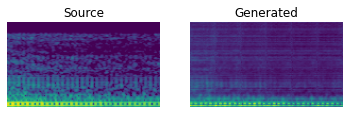

Mean D loss: 0.5004124045372009 Mean G loss: 0.6214392781257629 Mean ID loss: 0.10131783783435822
[Epoch 18/40] [Batch 0] [D loss f: 0.4850577712059021 r: 0.8826730847358704] [G loss: 0.6600618958473206] [ID loss: 0.102863609790802] [LR: 0.0002]
[Epoch 18/40] [Batch 600] [D loss f: 0.4739522337913513 r: 0.8803210258483887] [G loss: 0.6755365133285522] [ID loss: 0.10312259197235107] [LR: 0.0002]
[Epoch 18/40] [Batch 1200] [D loss f: 0.5023371577262878 r: 0.8708339333534241] [G loss: 0.6050994992256165] [ID loss: 0.09885641932487488] [LR: 0.0002]
[Epoch 18/40] [Batch 1800] [D loss f: 0.512259840965271 r: 0.8667408227920532] [G loss: 0.6061375737190247] [ID loss: 0.10118148475885391] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03425943448774134
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 604.86it/s, loss=6.28e-7, spectral_convergence=-32.3]


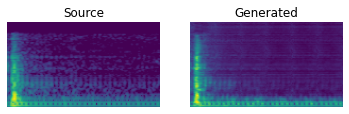

Mean D loss: 0.4978519678115845 Mean G loss: 0.6232556700706482 Mean ID loss: 0.10172908753156662
[Epoch 19/40] [Batch 0] [D loss f: 0.5050373077392578 r: 0.8634355068206787] [G loss: 0.5965012311935425] [ID loss: 0.10519742965698242] [LR: 0.0002]
[Epoch 19/40] [Batch 600] [D loss f: 0.5013201832771301 r: 0.8855137228965759] [G loss: 0.6309735178947449] [ID loss: 0.09984153509140015] [LR: 0.0002]
[Epoch 19/40] [Batch 1200] [D loss f: 0.5053918957710266 r: 0.8688724637031555] [G loss: 0.6103842854499817] [ID loss: 0.10515893250703812] [LR: 0.0002]
[Epoch 19/40] [Batch 1800] [D loss f: 0.5136045217514038 r: 0.8713743090629578] [G loss: 0.6202566623687744] [ID loss: 0.10129287838935852] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=1.83e-6, spectral_convergence=17.2]

Time/Batch 0.034280636861113586
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 596.47it/s, loss=1.32e-7, spectral_convergence=-2.31]


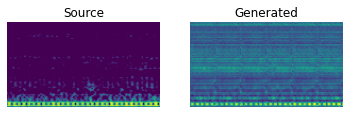

Mean D loss: 0.505397379398346 Mean G loss: 0.619695246219635 Mean ID loss: 0.10143997520208359
[Epoch 20/40] [Batch 0] [D loss f: 0.4981043338775635 r: 0.8735054731369019] [G loss: 0.6156455874443054] [ID loss: 0.09814709424972534] [LR: 0.0002]
[Epoch 20/40] [Batch 600] [D loss f: 0.48391759395599365 r: 0.8855619430541992] [G loss: 0.6079717874526978] [ID loss: 0.10040372610092163] [LR: 0.0002]
[Epoch 20/40] [Batch 1200] [D loss f: 0.5192314386367798 r: 0.864463210105896] [G loss: 0.5945636034011841] [ID loss: 0.09773217886686325] [LR: 0.0002]
[Epoch 20/40] [Batch 1800] [D loss f: 0.48723697662353516 r: 0.8962012529373169] [G loss: 0.613337516784668] [ID loss: 0.09718818962574005] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=7.49e-6, spectral_convergence=-4.49]

Time/Batch 0.03426585314396298
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 587.55it/s, loss=7.97e-7, spectral_convergence=-9.6]


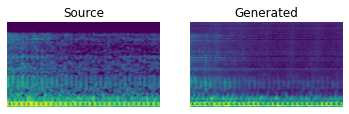

Mean D loss: 0.49819961190223694 Mean G loss: 0.6068163514137268 Mean ID loss: 0.09864943474531174
[Epoch 21/40] [Batch 0] [D loss f: 0.5054002404212952 r: 0.8822159767150879] [G loss: 0.6146684288978577] [ID loss: 0.09960715472698212] [LR: 0.0002]
[Epoch 21/40] [Batch 600] [D loss f: 0.4780671298503876 r: 0.911538302898407] [G loss: 0.6167370080947876] [ID loss: 0.10421007871627808] [LR: 0.0002]
[Epoch 21/40] [Batch 1200] [D loss f: 0.4931248426437378 r: 0.9105314016342163] [G loss: 0.6017476320266724] [ID loss: 0.10020387917757034] [LR: 0.0002]
[Epoch 21/40] [Batch 1800] [D loss f: 0.4995494484901428 r: 0.8794362545013428] [G loss: 0.6221799850463867] [ID loss: 0.09510083496570587] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0687, spectral_convergence=-.00336]

Time/Batch 0.03424040314666875
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 603.40it/s, loss=0.00314, spectral_convergence=-17.7]


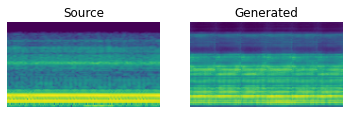

Mean D loss: 0.49332135915756226 Mean G loss: 0.6121447682380676 Mean ID loss: 0.09909096360206604
[Epoch 22/40] [Batch 0] [D loss f: 0.5084456205368042 r: 0.8812044858932495] [G loss: 0.6049770712852478] [ID loss: 0.09549237042665482] [LR: 0.0002]
[Epoch 22/40] [Batch 600] [D loss f: 0.5159549713134766 r: 0.87749844789505] [G loss: 0.6232934594154358] [ID loss: 0.10034188628196716] [LR: 0.0002]
[Epoch 22/40] [Batch 1200] [D loss f: 0.4760058522224426 r: 0.8705348968505859] [G loss: 0.6244619488716125] [ID loss: 0.09638933092355728] [LR: 0.0002]
[Epoch 22/40] [Batch 1800] [D loss f: 0.5028185844421387 r: 0.8791849613189697] [G loss: 0.6179710030555725] [ID loss: 0.09688472002744675] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.000193, spectral_convergence=-.0691]

Time/Batch 0.0341494307370166
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0           

100%|██████████| 2000/2000 [00:03<00:00, 612.03it/s, loss=3.75e-6, spectral_convergence=-17.4]


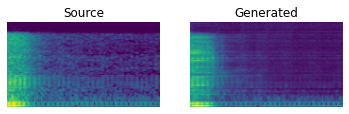

Mean D loss: 0.49995923042297363 Mean G loss: 0.6153252720832825 Mean ID loss: 0.09809433668851852
[Epoch 23/40] [Batch 0] [D loss f: 0.5092761516571045 r: 0.9007521867752075] [G loss: 0.5814829468727112] [ID loss: 0.09914181381464005] [LR: 0.0002]
[Epoch 23/40] [Batch 600] [D loss f: 0.5185754895210266 r: 0.8781296610832214] [G loss: 0.600419282913208] [ID loss: 0.09326957911252975] [LR: 0.0002]
[Epoch 23/40] [Batch 1200] [D loss f: 0.5037562251091003 r: 0.8762680888175964] [G loss: 0.5997707843780518] [ID loss: 0.09597194939851761] [LR: 0.0002]
[Epoch 23/40] [Batch 1800] [D loss f: 0.5018513202667236 r: 0.8881052732467651] [G loss: 0.6004223823547363] [ID loss: 0.09520038962364197] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=1.34e-5, spectral_convergence=-1.12]

Time/Batch 0.03413380212885315
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 602.18it/s, loss=7.34e-7, spectral_convergence=-10.4]


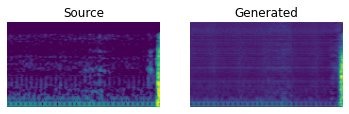

Mean D loss: 0.5061218738555908 Mean G loss: 0.6023571491241455 Mean ID loss: 0.09473475813865662
[Epoch 24/40] [Batch 0] [D loss f: 0.49683502316474915 r: 0.9020904898643494] [G loss: 0.6127541661262512] [ID loss: 0.09426027536392212] [LR: 0.0002]
[Epoch 24/40] [Batch 600] [D loss f: 0.5212648510932922 r: 0.8619089722633362] [G loss: 0.6060926914215088] [ID loss: 0.0923624038696289] [LR: 0.0002]
[Epoch 24/40] [Batch 1200] [D loss f: 0.493918240070343 r: 0.8999676704406738] [G loss: 0.5965588092803955] [ID loss: 0.09535810351371765] [LR: 0.0002]
[Epoch 24/40] [Batch 1800] [D loss f: 0.532402753829956 r: 0.8784700632095337] [G loss: 0.5688254833221436] [ID loss: 0.0926419049501419] [LR: 0.0002]
Time/Batch 0.03427905420747304
Saving...


  4%|▍         | 80/2000 [00:00<00:03, 624.15it/s, loss=0.362, spectral_convergence=-.382]

(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0                                            
______

100%|██████████| 2000/2000 [00:03<00:00, 607.03it/s, loss=0.00117, spectral_convergence=-22.3]


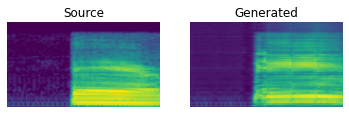

Mean D loss: 0.5173136591911316 Mean G loss: 0.5918611288070679 Mean ID loss: 0.09333888441324234
[Epoch 25/40] [Batch 0] [D loss f: 0.5242060422897339 r: 0.8892224431037903] [G loss: 0.5988966226577759] [ID loss: 0.09289565682411194] [LR: 0.0002]
[Epoch 25/40] [Batch 600] [D loss f: 0.5232032537460327 r: 0.8942482471466064] [G loss: 0.5745653510093689] [ID loss: 0.09345489740371704] [LR: 0.0002]
[Epoch 25/40] [Batch 1200] [D loss f: 0.5116263031959534 r: 0.8908213376998901] [G loss: 0.59519362449646] [ID loss: 0.09420736134052277] [LR: 0.0002]
[Epoch 25/40] [Batch 1800] [D loss f: 0.5224148631095886 r: 0.8884119391441345] [G loss: 0.5823910236358643] [ID loss: 0.08986619114875793] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.00801, spectral_convergence=-.00518]

Time/Batch 0.03421785697954664
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 608.86it/s, loss=2.91e-5, spectral_convergence=-21.3]


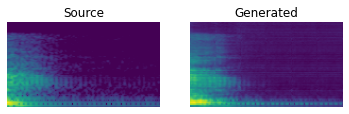

Mean D loss: 0.5185552835464478 Mean G loss: 0.5834250450134277 Mean ID loss: 0.0928148627281189
[Epoch 26/40] [Batch 0] [D loss f: 0.5152231454849243 r: 0.9040777683258057] [G loss: 0.5812200307846069] [ID loss: 0.09423795342445374] [LR: 0.0002]
[Epoch 26/40] [Batch 600] [D loss f: 0.5221746563911438 r: 0.8809190988540649] [G loss: 0.5777634978294373] [ID loss: 0.09441272914409637] [LR: 0.0002]
[Epoch 26/40] [Batch 1200] [D loss f: 0.5044353604316711 r: 0.9111177325248718] [G loss: 0.6030113697052002] [ID loss: 0.09007690101861954] [LR: 0.0002]
[Epoch 26/40] [Batch 1800] [D loss f: 0.48341211676597595 r: 0.9026450514793396] [G loss: 0.6236963868141174] [ID loss: 0.09096819907426834] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.034201891429994684
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 588.62it/s, loss=8.44e-7, spectral_convergence=-10.3]


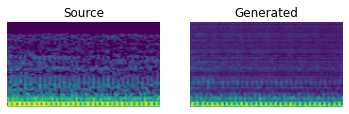

Mean D loss: 0.5057792067527771 Mean G loss: 0.5987082719802856 Mean ID loss: 0.09135463833808899
[Epoch 27/40] [Batch 0] [D loss f: 0.5178438425064087 r: 0.9033294320106506] [G loss: 0.5848826766014099] [ID loss: 0.0890003889799118] [LR: 0.0002]
[Epoch 27/40] [Batch 600] [D loss f: 0.5065388083457947 r: 0.9144606590270996] [G loss: 0.5775283575057983] [ID loss: 0.0864216759800911] [LR: 0.0002]
[Epoch 27/40] [Batch 1200] [D loss f: 0.5111930966377258 r: 0.8920099139213562] [G loss: 0.6072623133659363] [ID loss: 0.088859923183918] [LR: 0.0002]
[Epoch 27/40] [Batch 1800] [D loss f: 0.5050539970397949 r: 0.9083508253097534] [G loss: 0.5986372232437134] [ID loss: 0.08769406378269196] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.03e-6, spectral_convergence=4.27]

Time/Batch 0.0342486416615032
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0           

100%|██████████| 2000/2000 [00:03<00:00, 615.51it/s, loss=1.81e-7, spectral_convergence=-2.66]


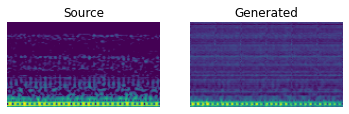

Mean D loss: 0.5080548524856567 Mean G loss: 0.5927358269691467 Mean ID loss: 0.08778683096170425
[Epoch 28/40] [Batch 0] [D loss f: 0.5102070569992065 r: 0.9178891777992249] [G loss: 0.5840993523597717] [ID loss: 0.08859506994485855] [LR: 0.0002]
[Epoch 28/40] [Batch 600] [D loss f: 0.49075326323509216 r: 0.9209480881690979] [G loss: 0.5989471673965454] [ID loss: 0.09028182178735733] [LR: 0.0002]
[Epoch 28/40] [Batch 1200] [D loss f: 0.5180903673171997 r: 0.8987151980400085] [G loss: 0.5696744322776794] [ID loss: 0.09311243146657944] [LR: 0.0002]
[Epoch 28/40] [Batch 1800] [D loss f: 0.5204633474349976 r: 0.9096133708953857] [G loss: 0.5750674605369568] [ID loss: 0.09085407108068466] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.22e-6, spectral_convergence=-3.58]

Time/Batch 0.03421663962156339
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 594.66it/s, loss=4.18e-7, spectral_convergence=-4.72]


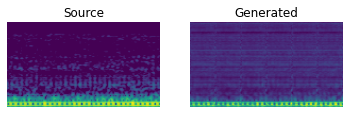

Mean D loss: 0.5145508050918579 Mean G loss: 0.5756829977035522 Mean ID loss: 0.09120877832174301
[Epoch 29/40] [Batch 0] [D loss f: 0.5387688875198364 r: 0.8874243497848511] [G loss: 0.5477059483528137] [ID loss: 0.09030458331108093] [LR: 0.0002]
[Epoch 29/40] [Batch 600] [D loss f: 0.4781052768230438 r: 0.9475034475326538] [G loss: 0.6045880913734436] [ID loss: 0.0886317566037178] [LR: 0.0002]
[Epoch 29/40] [Batch 1200] [D loss f: 0.5074042081832886 r: 0.9068196415901184] [G loss: 0.609321653842926] [ID loss: 0.08800594508647919] [LR: 0.0002]
[Epoch 29/40] [Batch 1800] [D loss f: 0.5141564011573792 r: 0.9167415499687195] [G loss: 0.579860508441925] [ID loss: 0.08792088180780411] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.36e-6, spectral_convergence=-2.89]

Time/Batch 0.034251118081413665
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 606.95it/s, loss=3.28e-7, spectral_convergence=-4.27]


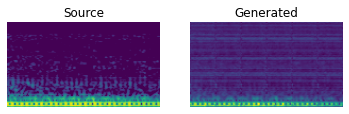

Mean D loss: 0.5024859309196472 Mean G loss: 0.5968892574310303 Mean ID loss: 0.08796673268079758
[Epoch 30/40] [Batch 0] [D loss f: 0.515653669834137 r: 0.9082959294319153] [G loss: 0.5914685130119324] [ID loss: 0.08660119771957397] [LR: 0.0002]
[Epoch 30/40] [Batch 600] [D loss f: 0.5084882974624634 r: 0.9295443892478943] [G loss: 0.5738349556922913] [ID loss: 0.08684191107749939] [LR: 0.0002]
[Epoch 30/40] [Batch 1200] [D loss f: 0.5149959325790405 r: 0.918392539024353] [G loss: 0.5856721997261047] [ID loss: 0.08582424372434616] [LR: 0.0002]
[Epoch 30/40] [Batch 1800] [D loss f: 0.5111299157142639 r: 0.9063405394554138] [G loss: 0.5757557153701782] [ID loss: 0.08606203645467758] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.79e-6, spectral_convergence=-2.87]

Time/Batch 0.03425104515467568
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 597.72it/s, loss=4.24e-7, spectral_convergence=-7.25]


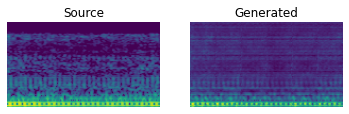

Mean D loss: 0.5076319575309753 Mean G loss: 0.5864169597625732 Mean ID loss: 0.08615285903215408
[Epoch 31/40] [Batch 0] [D loss f: 0.48810112476348877 r: 0.921916127204895] [G loss: 0.626434326171875] [ID loss: 0.08580724149942398] [LR: 0.0002]
[Epoch 31/40] [Batch 600] [D loss f: 0.5072262287139893 r: 0.9181929230690002] [G loss: 0.5887018442153931] [ID loss: 0.08926764130592346] [LR: 0.0002]
[Epoch 31/40] [Batch 1200] [D loss f: 0.506369411945343 r: 0.9152675271034241] [G loss: 0.5826473236083984] [ID loss: 0.08563466370105743] [LR: 0.0002]
[Epoch 31/40] [Batch 1800] [D loss f: 0.5163230299949646 r: 0.9027524590492249] [G loss: 0.5835670232772827] [ID loss: 0.0869491919875145] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0302, spectral_convergence=-.002]

Time/Batch 0.03426066497474398
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 608.16it/s, loss=0.000626, spectral_convergence=-18.6]


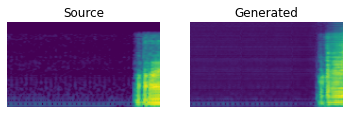

Mean D loss: 0.5130323767662048 Mean G loss: 0.5792233943939209 Mean ID loss: 0.08719945698976517
[Epoch 32/40] [Batch 0] [D loss f: 0.5300500988960266 r: 0.8979454040527344] [G loss: 0.54864501953125] [ID loss: 0.08670252561569214] [LR: 0.0002]
[Epoch 32/40] [Batch 600] [D loss f: 0.5061297416687012 r: 0.9339641332626343] [G loss: 0.5844839215278625] [ID loss: 0.08720549196004868] [LR: 0.0002]
[Epoch 32/40] [Batch 1200] [D loss f: 0.4938640296459198 r: 0.933692216873169] [G loss: 0.584514856338501] [ID loss: 0.08334331214427948] [LR: 0.0002]
[Epoch 32/40] [Batch 1800] [D loss f: 0.5043957233428955 r: 0.9230130910873413] [G loss: 0.574215829372406] [ID loss: 0.08828330039978027] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.000131, spectral_convergence=-1]

Time/Batch 0.034281440268838254
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 606.79it/s, loss=5.83e-6, spectral_convergence=-26.4]


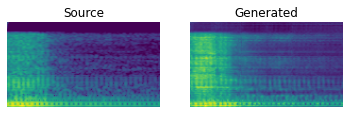

Mean D loss: 0.5018709897994995 Mean G loss: 0.5834473371505737 Mean ID loss: 0.08695024996995926
[Epoch 33/40] [Batch 0] [D loss f: 0.5028179883956909 r: 0.9248754382133484] [G loss: 0.5963496565818787] [ID loss: 0.09027130901813507] [LR: 0.0002]
[Epoch 33/40] [Batch 600] [D loss f: 0.50384920835495 r: 0.9114319682121277] [G loss: 0.5788084268569946] [ID loss: 0.08697979897260666] [LR: 0.0002]
[Epoch 33/40] [Batch 1200] [D loss f: 0.4792662560939789 r: 0.9449654221534729] [G loss: 0.6021859645843506] [ID loss: 0.08427917212247849] [LR: 0.0002]
[Epoch 33/40] [Batch 1800] [D loss f: 0.498902291059494 r: 0.9322385787963867] [G loss: 0.6058753728866577] [ID loss: 0.08240439742803574] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.0935, spectral_convergence=-.000744]

Time/Batch 0.034216355306580355
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0         

100%|██████████| 2000/2000 [00:03<00:00, 609.09it/s, loss=0.00117, spectral_convergence=-15.6]


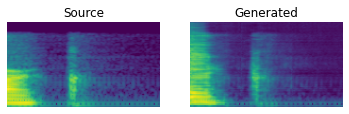

Mean D loss: 0.49354326725006104 Mean G loss: 0.5989596247673035 Mean ID loss: 0.08403684198856354
[Epoch 34/40] [Batch 0] [D loss f: 0.4907344579696655 r: 0.912954568862915] [G loss: 0.61604905128479] [ID loss: 0.08152712881565094] [LR: 0.0002]
[Epoch 34/40] [Batch 600] [D loss f: 0.49293065071105957 r: 0.9356823563575745] [G loss: 0.5871931910514832] [ID loss: 0.08414704352617264] [LR: 0.0002]
[Epoch 34/40] [Batch 1200] [D loss f: 0.506173849105835 r: 0.9161302447319031] [G loss: 0.5814612507820129] [ID loss: 0.08432409167289734] [LR: 0.0002]
[Epoch 34/40] [Batch 1800] [D loss f: 0.5000301599502563 r: 0.9243177175521851] [G loss: 0.5963848233222961] [ID loss: 0.0824124813079834] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=8.64e-6, spectral_convergence=-5.28]

Time/Batch 0.03430461883544922
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 610.83it/s, loss=1.23e-6, spectral_convergence=-14]


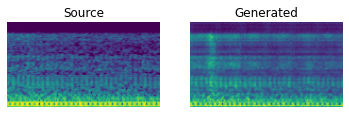

Mean D loss: 0.5045814514160156 Mean G loss: 0.5838483572006226 Mean ID loss: 0.08298107236623764
[Epoch 35/40] [Batch 0] [D loss f: 0.5293673276901245 r: 0.9112882614135742] [G loss: 0.5609115362167358] [ID loss: 0.07971877604722977] [LR: 0.0002]
[Epoch 35/40] [Batch 600] [D loss f: 0.5034421682357788 r: 0.9273101687431335] [G loss: 0.576006293296814] [ID loss: 0.08274822682142258] [LR: 0.0002]
[Epoch 35/40] [Batch 1200] [D loss f: 0.4927245080471039 r: 0.9237310886383057] [G loss: 0.5866855978965759] [ID loss: 0.08483069390058517] [LR: 0.0002]
[Epoch 35/40] [Batch 1800] [D loss f: 0.49081239104270935 r: 0.933300793170929] [G loss: 0.5946071147918701] [ID loss: 0.08276212215423584] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.147, spectral_convergence=-.000505]

Time/Batch 0.03432888942755576
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 601.52it/s, loss=0.000126, spectral_convergence=-41.1]


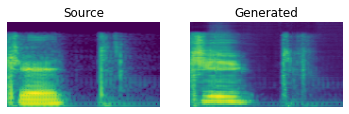

Mean D loss: 0.49671754240989685 Mean G loss: 0.5837560296058655 Mean ID loss: 0.08357729762792587
[Epoch 36/40] [Batch 0] [D loss f: 0.5011945962905884 r: 0.9189117550849915] [G loss: 0.5745445489883423] [ID loss: 0.084236279129982] [LR: 0.0002]
[Epoch 36/40] [Batch 600] [D loss f: 0.48532578349113464 r: 0.9374698996543884] [G loss: 0.5629726052284241] [ID loss: 0.08578645437955856] [LR: 0.0002]
[Epoch 36/40] [Batch 1200] [D loss f: 0.49604806303977966 r: 0.9458240866661072] [G loss: 0.5757797956466675] [ID loss: 0.08175137639045715] [LR: 0.0002]
[Epoch 36/40] [Batch 1800] [D loss f: 0.48722559213638306 r: 0.9416921734809875] [G loss: 0.5802845358848572] [ID loss: 0.08209605515003204] [LR: 0.0002]
Time/Batch 0.03435427002860462
Saving...


  4%|▍         | 80/2000 [00:00<00:03, 602.57it/s, loss=6.06e-6, spectral_convergence=-10.3]

(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0                                            
______

100%|██████████| 2000/2000 [00:03<00:00, 600.14it/s, loss=1.79e-6, spectral_convergence=-13.7]


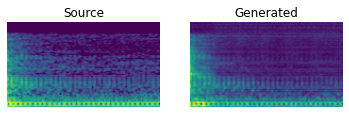

Mean D loss: 0.48900407552719116 Mean G loss: 0.5786246657371521 Mean ID loss: 0.08301316201686859
[Epoch 37/40] [Batch 0] [D loss f: 0.4861936569213867 r: 0.9481167197227478] [G loss: 0.6067984700202942] [ID loss: 0.08200272172689438] [LR: 0.0002]
[Epoch 37/40] [Batch 600] [D loss f: 0.4985142648220062 r: 0.921668291091919] [G loss: 0.5981277227401733] [ID loss: 0.08361983299255371] [LR: 0.0002]
[Epoch 37/40] [Batch 1200] [D loss f: 0.48800739645957947 r: 0.9362536668777466] [G loss: 0.5919694900512695] [ID loss: 0.08281480520963669] [LR: 0.0002]
[Epoch 37/40] [Batch 1800] [D loss f: 0.49424025416374207 r: 0.948255717754364] [G loss: 0.5729642510414124] [ID loss: 0.0834658071398735] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03448491337011391
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 607.83it/s, loss=0.00305, spectral_convergence=-18.5]


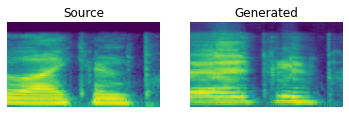

Mean D loss: 0.5002394318580627 Mean G loss: 0.5770149827003479 Mean ID loss: 0.08320551365613937
[Epoch 38/40] [Batch 0] [D loss f: 0.5334493517875671 r: 0.925434410572052] [G loss: 0.5238776206970215] [ID loss: 0.08273020386695862] [LR: 0.0002]
[Epoch 38/40] [Batch 600] [D loss f: 0.5061507225036621 r: 0.9309472441673279] [G loss: 0.5607703924179077] [ID loss: 0.08211752772331238] [LR: 0.0002]
[Epoch 38/40] [Batch 1200] [D loss f: 0.484406977891922 r: 0.9614986181259155] [G loss: 0.5956710577011108] [ID loss: 0.08349446952342987] [LR: 0.0002]
[Epoch 38/40] [Batch 1800] [D loss f: 0.5282352566719055 r: 0.9271838665008545] [G loss: 0.5570220351219177] [ID loss: 0.08154967427253723] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.12, spectral_convergence=-.000939]

Time/Batch 0.03435794935354421
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 612.00it/s, loss=0.000209, spectral_convergence=-54.3]


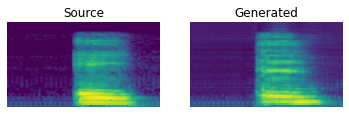

Mean D loss: 0.5032115578651428 Mean G loss: 0.5734524726867676 Mean ID loss: 0.08239486068487167
[Epoch 39/40] [Batch 0] [D loss f: 0.48785004019737244 r: 0.9487115740776062] [G loss: 0.5849350690841675] [ID loss: 0.08241046220064163] [LR: 0.0002]
[Epoch 39/40] [Batch 600] [D loss f: 0.4793630540370941 r: 0.942635715007782] [G loss: 0.5980759859085083] [ID loss: 0.08436106145381927] [LR: 0.0002]
[Epoch 39/40] [Batch 1200] [D loss f: 0.5071156620979309 r: 0.9336625933647156] [G loss: 0.5764597654342651] [ID loss: 0.08105196803808212] [LR: 0.0002]
[Epoch 39/40] [Batch 1800] [D loss f: 0.505902886390686 r: 0.9393956661224365] [G loss: 0.5758128762245178] [ID loss: 0.0795874148607254] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=3.19e-6, spectral_convergence=-6.6]

Time/Batch 0.03433059608974925
Saving...
(6, 80, 24, 1)
Results mid-training for generation of random spectrograms and audio files. 
Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 2)        16          input_80[0][0]                   
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 2, 24)        0           embedding_24[0][0]               
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 80, 24, 1)]  0          

100%|██████████| 2000/2000 [00:03<00:00, 587.23it/s, loss=5.36e-7, spectral_convergence=-6.91]


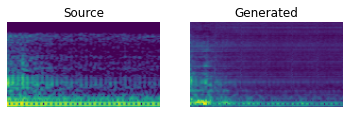

Mean D loss: 0.49975359439849854 Mean G loss: 0.5798538327217102 Mean ID loss: 0.08137670904397964


In [174]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(40, batch_size=bs, lr=0.0002, n_save=1, gupt=3)

Next steps:
The speaker embedding model seems to work with a speaker vector of just ones. The next step is to feed different values to the generator to be concatenated to the input, depending on the target speaker.
For this, it is necessary to figure out what target speaker we are looking at.
The main question is: where do we do this in the model? We don't really know what target speaker we're getting until the discriminator (?). 
Ask about this on Monday. 
Until then, read about it and gather ideas, try out some things, but don't go overboard. Upload this code to github. 


In [175]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  print(imlast.shape)
  dsa.append(imlast)
  print(np.array(dsa, dtype=np.float32).shape)

  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec) #Chop source spectrogram into chunks of equal size
  print(f"specarr: {specarr.shape}")
  a = specarr #WE'RE PASSING ALL CHUNKS AS AN ARRAY, INSTEAD OF EACH CHUNK, ONE BY ONE?
  batch_size = specarr.shape[0]
  testing_vector = np.ones((batch_size, 24))
  print(testing_vector)
  ab = gen([a, testing_vector], training=False) #Cannot concatenate these two inputs. 
  gen.summary()
  #Maybe i can do it like during training, pass it one by one and then concatenate? - Doesn't work
  #Try to change the speaker_id vector at test time to match the batch size?
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

(69237,)


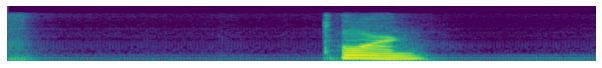

  0%|          | 0/2000 [00:00<?, ?it/s, loss=0.01, spectral_convergence=-.00768]

(80, 24, 1)
(37, 80, 24, 1)
specarr: (37, 80, 24, 1)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

100%|██████████| 2000/2000 [00:02<00:00, 674.86it/s, loss=0.0175, spectral_convergence=-16]


Saving...
Saved WAV!


In [178]:
#Wav to wav conversion

wv, sr = librosa.load('/content/INP/MC01_10017.wav', sr=22050)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME5', path='../content/')           #Convert and save wav